In [1]:
import sys
sys.path.append('/Users/samrelins/Documents/LIDA/ace_project/')
from src.train_test import *
import plotly.express as px
from sklearn.ensemble import GradientBoostingClassifier

data_dir = "/Users/samrelins/Documents/LIDA/ace_project/data/"
filename = "ace_data_orig.csv"
ace_data_orig = pd.read_csv(data_dir + filename)

X_train, y_train, X_test, y_test = return_train_test(ace_data_orig)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samrelins/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samrelins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Tree Models

Decision trees are one of the most popular predictive models in the world of
machine learning. Modern ML packages include a wide range of different
tree-based ML models that can be easily applied to almost any predictive
task, and often result in the highest accuracy among their peers. Hence,
decision trees sit behind a vast
 number of AI solutions (probably the majority - don't quote me on that). So it
  shouldn't come as a surprise that the tree models are currently
best predictors of success in the ACE service.

In this notebook we'll take a look at the most successful of the models we've
 trained so far, the Gradient Boosted Decision Trees Classifier. Much like the
 name,
 the theory behind this model is pretty verbose, so I've stuck it in an
 appendix at the end. That said, it is
  useful to understand the workings of decision tree ensembles when
  considering these results (and, besides that, it took me hours to write!) so
  I hope you'll give it a once over! And with that, let's take a look at
  the cream of the current crop:

## Model Training and Performance Evaluation

As before, we'll first run the model through our training loop to establish
the best parameters, and validation scores from the training dataset. As we
did previously, lets plot the model's predictions for each example against
the true label:

In [2]:
best_scores, best_params = param_search_classifier(
    X_train=X_train, y_train=y_train,
    clf = GradientBoostingClassifier(),
    cat_encoder="one_hot",
    param_grid = {'learning_rate': [0.02],
                  'n_estimators': [int(x) for x in np.linspace(5, 50, 10)],
                  'max_depth': np.linspace(1, 10, 10),
                  'min_samples_split': [int(x) for x in np.linspace(10, 100,
                                                                    10)],
                  'max_features': np.logspace(-2,-0.1,10)},
    weight_y=True
)

Testing GradientBoostingClassifier() classifier with one_hot encoded features.


  2%|▏         | 240/10000 [00:44<30:07,  5.40it/s]


KeyboardInterrupt: 

### Best Parameters

In [ ]:
pd.DataFrame({
    "parameter": best_params.keys(),
    "value": best_params.values()
})

It's worth noting that the particular gradient boosting model I'm using (as
with most others) has
non-deterministic (i.e. random) elements that mean the optimal result can
differ each time
you fit the model. In this case, the optimal features show significant
variance each this search is run e.g. one such search resulted in
"min_samples_split": 10 then the next was 80. This variance is likely to be a
 symptom of the very small dataset and the lack of clear features to divide
 the different classes (hospital treatment required or not).

This wide variance is observed with most of the features (max_depth,
max_features, min_sapmples_split). The only common feature between the
optimal solutions is a very low **n_estimators** - in a typical gradient
boosted solution this would be 100 or more, but the best solutions for the
ACE dataset have been either 5 or 10 estimators.

This variance evidently carries acrross to the validation and test scores,
though the effect is minimal i.e. each solution results in very similar scores:

### Cross Validation Scores:

In [ ]:
pd.DataFrame(best_scores, index=[""]).T

In [ ]:
X_train_prepped, X_test_prepped = encode_and_scale(
    X_train=X_train, y_train=y_train, X_test=X_test,
    cat_encoder="one_hot",
    scaled=False,
)

pos_weight, neg_weight = compute_class_weight(
    class_weight="balanced",
    classes=[1,0],
    y=y_train)
y_weights = y_train.apply(lambda y: pos_weight if y else neg_weight)

grad_boost_clf = GradientBoostingClassifier(**best_params)

grad_boost_clf.fit(X_train_prepped, y_train,
                   sample_weight=y_weights)

### Test Scores:

In [ ]:
test_scores = score_classifier(grad_boost_clf, X_test_prepped, y_test)
pd.DataFrame(test_scores, index=[""]).T

The validation and test scores are better (though in the same ballpark) as the
 logistic regression model we looked at last time.

## Feature exploration

This is the point at which we usually "take a look under the hood" of our
model and see how it's making predicitons. We have an issue, however. Given
that decision tree ensembles are comprised of many complimentary decision
trees, it's very difficult to grasp **how** they come to make the predictions
 they've made. Unlike logistic regression, we don't have one (and only one)
 coefficient that corresponds with each term, that we can look at to
 determine its effects on the output. In ML terms, they aren't
 globally explainable:

If, for example, `referral_from_gp` features prominently in many of the
trees, we might call it an important feature. But it's effects on the
output may differ, depending on the age of the example, or the combination of
 age and address, or any other combination of features. So its importance
 varies from example to example. In general, the effect an example's
 individual features has on the model's output varies in combination with
 the other features, making it challengin to work out what the model is doing.

Thankfully there are a raft of explainability methods out there that can help
 us gain an understanding of how a model is making decisions. For the moment,
  we'll focus on one:

## SHAP

SHAP (or SHapely Additive exPlanations) is a tool that helps us understand
the influence each feature has on the output / predicitons of an ML model;
and that is meant in the most general of terms - it can be used to explain
the outputs of pretty much any predictive models, from linear regression to
deep neural networks. SHAP uses a "game theoretic" approach to probing each
feature to asses it's influence on others, on an example by example basis.
The theory is outside the scope of this notebook (thankfully), but the
results of SHAP analysis are fairly intuitive.

We'll start simply by looking at the shap analysis of the first example in
our dataset:

#### example # 1:

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(grad_boost_clf)
shap_values = explainer.shap_values(X_test_prepped)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value,
                shap_values[0,:], X_test_prepped.iloc[0,:],
                link="logit")

So the above plot show's the probability this particular example requires
hospital treatment in the center. The red and blue arrows to the left and
right of the prediction show each of the features and the amount of influence
 they have on this prediction - the length of the arrow being proportional to
  the magnitude they add or substract from the predicted probability.

Each example will have a different combination of features, and each feature
will have different effects in the presence of the others:

#### example #46

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values[46,:], X_test_prepped.iloc[46,:],
                link="logit")

In [ ]:
#### example #103

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values[103,:], X_test_prepped.iloc[103,:],
                link="logit")

We can use these values to gain an overall picture of the influence of each
feature across the whole dataset like so:

In [ ]:
shap.summary_plot(shap_values, X_test_prepped)

This plot shows scatter plots of the shapvalues for each feature coloured by
their value (blue means low red means high). This can help us to see more
general patterns in the effects of different features. For example we can see
 the binary (1=yes, 0=no) features tend to allign on one or other side of the
  x axis, and so are generally either increasing or decreasing the
  probability of hospital treatment.

We can be even more fancy and plot an interactive chart of the shap values
like so:

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_test_prepped)

By changing the values in the drop-down menus (top and left of the chart) we
can compare the effects of each feature against the overall output, or
against eachother to see how different features combine. This particualar
chart is a little complex so I'd encourage playing around with it (or if you
like, I can provide a live explanation next time we speak)

## Evaluating the Model

By this point, you may notice we haven't stopped to describe any of the
features the model deems useful, and with good reason. The above
analysis primarily shows that the model isn't doing much of anything useful
at all! This can perhaps best be shown with a plot of its predictions
against the true labels (you may remember this from the similar plot in the
previous notebook):

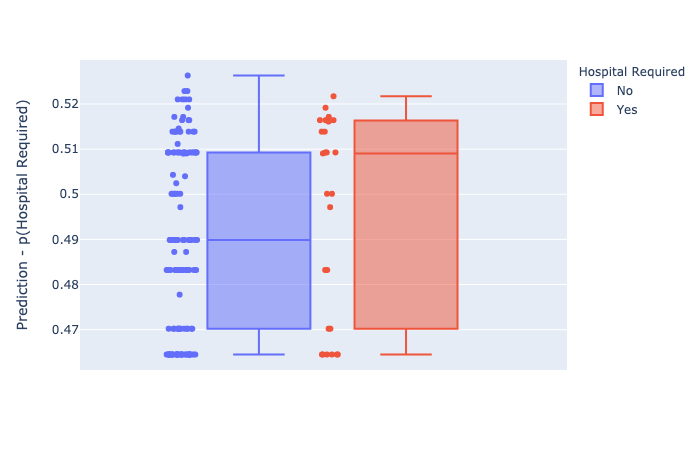

In [13]:
y_test_labels = y_test.apply(lambda y: "Yes" if y else "No").values
l1_prob_preds = grad_boost_clf.predict_proba(X_test_prepped)[:,1]

y_sort_idxs = np.argsort(y_test)
predictions_df = pd.DataFrame({
    "Hospital Required": y_test_labels[y_sort_idxs],
    "Prediction - p(Hospital Required)": l1_prob_preds[y_sort_idxs]

})

fig = px.box(predictions_df,
             y="Prediction - p(Hospital Required)",
             color="Hospital Required",
             points="all")
# fig.update_layout(yaxis_range=[0.25, 0.75])
fig.show(renderer="png")


Again, there seems to be a slight, though small relationship between the true
 label and the model's predictions. The real issue, however, becomes clear if
  we adjust the scale of the y-axis:

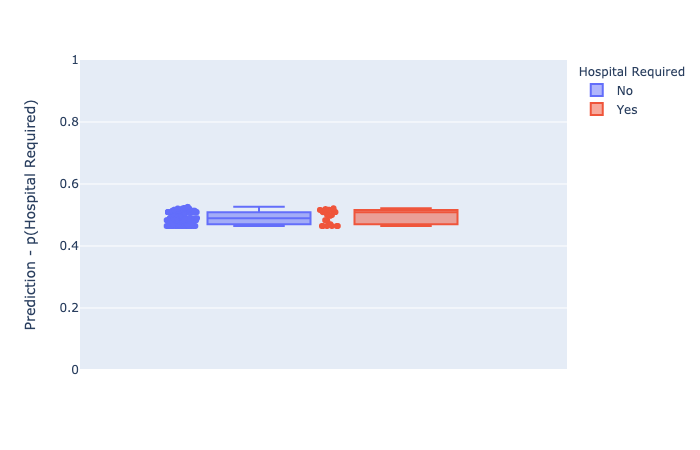

In [14]:
fig.update_layout(yaxis_range=[0.0, 1])
fig.show(renderer="png")


The model is predicting a near enough 50% chance that every example needs
hospital treatment! It's only for slight fractions of a percent either side
of this 50% that it classifies **any** of the examples correctly.

## Conclusions

All of this really serves to reiterate what I've been saying for the last
couple of months. We don't have a dataset that can be well modelled using the
 standard ML toolkit. The above should also make it clear that we need a
 better way of defining certainty / uncertainty rather than optimising our
 models to output a single prediction. Hence the focus moving forwards will be:

* adding whatever extra features we can get our hands on. This
will primarily be the free-text notes from the ACE records, and hopefully primary
care data from the connected yorkshire dataset.
* bayesian modelling - if we take a more probabilistic approach, we may be
able to build a model that can find stronger relationships in parts of
the dataset and identify where there are areas of uncertainty

# Appendix - Decision Trees and Ensembles

## The Basics - Desision Trees

One of the great things about decision trees is the simplicity of the theory
 on which they are based. We'll start by taking a quick tour of the basics.
On the way, we'll use the following dataset of people's opinions on The Lord of
the Rings, alongside their abilities to sit and pay attention:

In [15]:
lotr_df = pd.DataFrame({
    'loves the book':[True, False, True, False, True, False, True, False],
    "max attention span": [210, 320, 300, 220, 180, 90, 230, 210],
    "loves the film":["yes", "no", "yes", "no", "no", "no", "yes", "no"]
})
lotr_df

,loves the book,max attention span,loves the film
0,True,210,yes
1,False,320,no
2,True,300,yes
3,False,220,no
4,True,180,no
5,False,90,no
6,True,230,yes
7,False,210,no


*(disclaimer for any die-hard LOTR fans - this is a fictional dataset,
designed to be easily separated classified by a decision tree, and in
 no way reflects genuine opinions on the Lord of the Rings films / books. I'm
  sure most folk love them.)*

Imagine we needed to create a model that predicted if one of the above folk
loves the Lord of the Rings films. This can easily be done with a decision tree:

[Text(334.8, 453.0, "node #0\nloves the book <= 0.5\ngini = 0.469\nsamples = 100.0%\nvalue = [0.625, 0.375]\nclass = doesn't love the film"),
 Text(167.4, 271.8, "node #1\ngini = 0.0\nsamples = 50.0%\nvalue = [1.0, 0.0]\nclass = doesn't love the film"),
 Text(502.20000000000005, 271.8, 'node #2\nattention span (mins) <= 195.0\ngini = 0.375\nsamples = 50.0%\nvalue = [0.25, 0.75]\nclass = loves the film'),
 Text(334.8, 90.59999999999997, "node #3\ngini = 0.0\nsamples = 12.5%\nvalue = [1.0, 0.0]\nclass = doesn't love the film"),
 Text(669.6, 90.59999999999997, 'node #4\ngini = 0.0\nsamples = 37.5%\nvalue = [0.0, 1.0]\nclass = loves the film')]

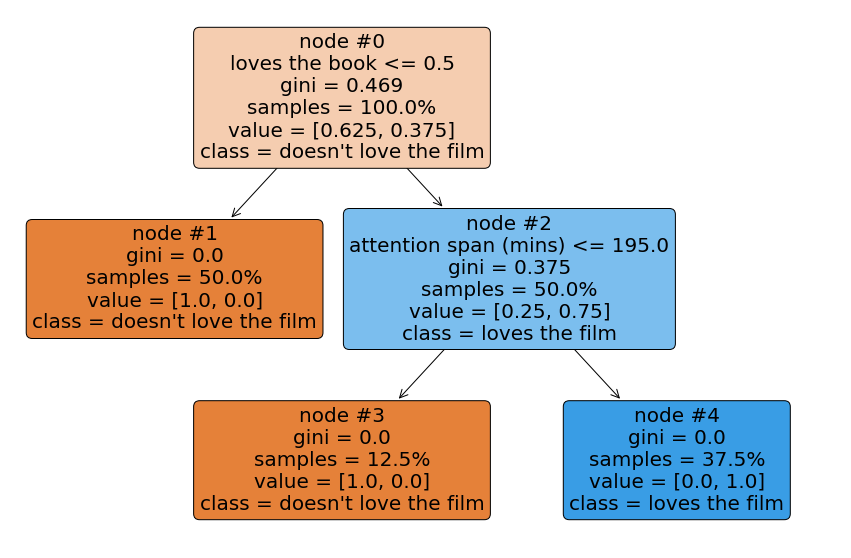

In [16]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_clf = DecisionTreeClassifier()
tree_clf.fit(lotr_df.iloc[:,:-1], lotr_df.iloc[:,-1])

plt.figure(figsize=(15,10))
plot_tree(tree_clf,
          feature_names=["loves the book", "attention span (mins)"],
          class_names=["doesn't love the film", "loves the film"],
          filled=True,
          rounded=True,
          node_ids=True,
          fontsize=20,
          proportion=True)

If that looks a little complex, don't worry! Decision trees are just a
collection of decisions that divide the data into two parts. It's easiest to
follow the logic of a decision tree by classifying a new example, so let's do that:

Take a new person that **loves the book** and has an **attention span of 310 minutes** - we'll use the above tree to classify this new person, starting from the top and working down, as follows:

* **node #0 / root node**
we're first asked if "loves the book" is less than
 0.5. Decision trees will usually classify everything numerically and ask
 "less than" or inequality questions. So this is equivalent to asking if
 someone loves the book, with a
value of 1, or doesn't love the book, with a value of 0. Those values less
 than go on the left, and greater than go on the right. Our example
loves the book, which is greater than 0.5, so we follow the right arrow or
"branch" to the next node **node #2**

* **node #2**
this node asks if "attention span" is less than 195 mins. Our example has an
 attention span of 310 mins which is greater than 195 minutes, so again we
 travel down the right branch to **node #4**

* **node #4**
we don't have any further inequality statement at this node, nor any branches
 leading from it, so we've reached what we call a "leaf node". We classify our
 example according to the label at this node, which is "loves the film".

So if we now consider classifying the whole dataset, as you move down the tree,
gradually it separates the data into "chunks". Each successive "chunk"
contains a greater majority of one or other of the classes. We can observe this by looking at the colors of each node in the tree:
* the more <span style="color:darkorange">orange</span> a node is, the more
examples it
contains that
<span style="color:darkorange">don't
like
the film</span>
* the more <span style="color:#399DE5">blue</span> a node is, the more
examples it
contains that <span style="color:#399DE5">do like the film</span>

*Note: that the **"class ="** statements at the bottom of each node represent
 the majority class.*

So the first node, representing the whole dataset, starts slightly orange, as a
small majority of the people in the dataset don't love the film (5/8). We
then see the data divide into
greater majorities of folk who love the film - **node #2** to **node #4** -
and who don't love the film - **nodes #3 and #4**. In the end, every leaf
node has a 100% majority of one or other of the classes.

So we can see the tree has found an overall rule that correctly classifies the
entire dataset with 100% accuracy. Magic!


### Building a Decision Tree

Hopefully, you're convinced this decision tree is pretty easy to interpret.
Thankfully, decision trees are also pretty simple to build - several
 algorithms are available, but each follow the same basic principles:

1. Take each of your features and divide them into different "less than"
decisions. With categorical features, this is as simple as the example we've already
seen i.e. **part of group <= 0.5**. For continuous features we simply order each
 feature low-high (or visa versa):

<table style="margin-left:30px">
    <tr>
        <th>max attention span</th>
        <td>90</td> <td>120</td> <td>180</td> <td>200</td>
        <td>210</td> <td>220</td> <td>230</td> <td>300</td>
    </tr>
</table>
<div style="margin-left:30px">and then pick values in between each of the
observations to make "less than" inequality decisions e.g. <b>max attention
span <= one of 105 / 150 / 190</b> etc..</div>

2. Use each of these decision rules to divide the dataset into chunks. Work out
the proportion of different labels (loves / doesn't love the film) in each of
these chunks and assign it an "impurity score". The higher the score, the
more of a mix of labels there is. For example, a score of zero means all the
data has the same label, a score of one (usually) means an even distribution of all the labels (in our example 50/50).

  *Note: these impurity scores can be seen in our tree diagram above under "**gini =**" (gini is a
  type of impurity score).*

3. Choose the decision that makes chunks with the lowest combined impurity
score (weighted by the number of examples). Make that a new node. Treat the
chunks this node creates as new start points.

4. Repeat from step 1 for each of the new chunks / start points. Note: this
will gradually remove potential options from the list of binary decisions -
so if we pick "loves the book <= 0.5" obviously that is no longer an option
further down the tree

5. Once each leaf is pure, that is, it contains only examples of one label,
or reaches a pre-determined minimum number of examples - stop!
 classify all the examples that reach this point with the majority label from
  the data at this node. This is now a leaf
 node.

6. Repeat steps 1 to 5 until each pathway of branches ends with a leaf node.

Easy!

## The Drawbacks

Decision trees are brilliantly simple to design and to use, but are rarely
applied to actual predictive tasks in this form. Simple trees like that above
have some key drawbacks that the statistically-minded among us will quickly notice:

* **Overfitting** - If you follow the above algorithm without setting a
minimum number of examples at each node, you will always
 end up with a decision tree that perfectly classifies your data. This means your
tree is simply memorising the labels from the training data, and will
classify all examples based on this. This is obviously not going to work very
 well when applied to new data. Even if we do specify a minimum number of
 examples at each node (or other regularisation techniques) we still often
 end up overfitting the training data.
* **High Variance** - Decision trees are highly sensitive to changes in the
data - a small shift in the dataset can result in a completely different set
of rules and thus a different set of predictions. Put simply, decision
trees are flippant, and will easily change their mind with only small changes
 to the data.
* **Non-optimal Solutions** - Though there may be a perfect way to divide
your data into binary decisions, there is no guarantee the decision tree
algorithm will find this solution. For example, we can easily think of a
problem for which the best classifier begins by dividing the data into two
groups, each with an even proportion of classification
labels - a decision tree algorithm will never pick this decision as it will
have the worst possible impurity score.
* **Low Accuracy** - because of the above, and simply that data rarely
separate optimally into one pathway of binary decisions, decision trees are
rarely accurate in practice.

So where do we go from here? There is one key concept that
takes the simple decision trees we've seen and turns them into the predictive
powerhouse of modern ML!

## Ensembles

An ensemble is a group of individual predictive models that combine their
predictions, like votes in an election. Each model is capable of making its
own prediction, but grouped together the different "opinions" combine to form
 one majority decision. Tree models, though inaccurate and flippant decision
 makers on their own, become a force to be reckoned with when combined to
 form an ensemble!

Though the basic principle of "stack lots of tree models together" is pretty
simple, in practice there are a number of different ways to do this. The
following are among the most popular, and also happen to be the three tree
models we used to classify the ACE data in the initial exploration:

### Random Forest

A random forest model takes the basic decision tree model, using it
 to build tens, or even hundreds, of complimentary decision trees. If we were
  to do this just using the base decision tree algorithm (described above)
  over and over, we would just end up with multiple identical trees. As such, the random forest
   algorithm includes some key adjustments:

1. Create a "bootstrap dataset" for each tree - this is simply a collection
of randomly selected datapoints from the training dataset. The bootstrap data
 is the same size as the original training data, but the random selection
 allows the same data points to be chosen more than once.
2. At each node of the decision tree, take a random sub-sample of the
features from which to create your decision for that node. This is usually a
proportion of the features in the region of 30-50%

Note: in reality there are several adjustments one can make when training a
random forest, these are just two of the most popular

The end result is that each tree only "sees" a subset of the data when
training and so "specialises" in finding useful predictors from that part of
the dataset. We then combine the predictions of each tree with equal
weighting to make our overall prediction.

Random forests are the original of the tree-based ensembles and are very
effective classifiers. Note that each individual tree is independent of the
next and contributes equally to the final output. This is the key difference
between random forests, and the more modern "boosted" tree-ensembles that
follow:

### AdaBoost

AdaBoost (short for "adaptive boosting") is a decision tree ensemble that
iteratively improves its decisions with each new tree. In plain english: it
builds a tree, then the next tree improves on the classification of that
tree, then the next tree improves upon that and so on and so on. Note that
the decisions of each tree depend on those before it, and so the decision
makers are no longer independent like those in a random forest. The result is
 a classifier that gradually works towards one answer, rather than cobbling
 together several competing answers like a random forest. This often results
 in more accurate classifications.

The principles of AdaBoost are as follows:

* Each decision tree is made up of only **one node** which, of course,
classifies the results into one of two categories. In the biz, a decision
tree with only one decision node is called a "stump".
* Each subsequent tree in the chain is trained on the examples the previous
 tree classified incorrectly, the "iterative improvement" mentioned above.
* The predictions of each tree, the "final say" each tree has, are weighted
according to the number of examples each tree correctly classifies. So a
stump that gets more right answers has a greater share of the final say.

These are the basic principles from which follow myriad additional
complications and caveats, but it's a good overview for those that don't have
 all day to read about AdaBoost.

Next is the second of our boosted tree ensembles and our final example:

### Gradient Boosted Trees

Gradient boosted trees are something of a superstar in the ML world and have
lead to two of the most popular and utilised python ML libraries out there -
XGBoost and LightGBM. This is somewhat unusual given that both specialise in
implementing only one type of model! That all goes to say, gradient boosting
is a pretty handy technique.

The theory behind gradient boosting is a (sort of) combination of AdaBoost
and Random Forests. The first principle of gradient boosting is that, unlike
the other techniques we've discussed, each classifier makes predictions like
a logistic / linear regression model. In the case of a classifier model, this
 is a pseudo probability, indicating the likelihood a datapoint belongs to
 one class or another.

Keeping this quirk at the forefront of our minds a gradient boosted tree
works as follows:

1. We begin with a simple classifier that just outputs the mean label, with
the corresponding proportion as a probability i.e. in our LOTR example, 5/8
people didn't like the film, so the first classifier would predict "doesn't
like the film" with a probability 5/8 = 0.625
2. We calculate "residuals" for every example in our dataset. This is the
amount this prediction was "off the mark". So the residual
for a datapoint that liked the film would be 1 (the correct probability) - 0
.625 (the predicted probability) = 0.375. Conversely, the residual for
somebody that doesn't like the film is 0 (the correct probability) - 0.625 =
0.625 (as an absolute value, we don't bother with the minus).
3. The next classifier is a decision tree as we've discussed, but it **predicts
the residuals from stage 2** i.e. it predicts the mistakes the first tree
made.
4. We combine the overall probabilities the first tree predicted with the second
tree's predictions of the residuals, but the residuals from the second tree are
multiplied by a small weight. This results in the model taking small "steps"
 towards the right answer, rather than leaping towards it in one go which
 results in overfitting.
5. Calculate the residuals of these new combined predictions and repeat from
step 3 until you get to the optimal answer. That way, each subsequent tree
iteratively improves on the predictions from the previous tree, taking little
 steps toward the right answer.

Again, there's a lot more to gradient boosting, but the above gives a good
idea of the basics. Like AdaBoost, gradient boosting often
results in more accurate predictions than random forests, given its
iterative approach to forming predictions.

